In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm

from pathlib import Path
from patsy import dmatrices

from notears import nonlinear, linear, utils
from graphviz import Digraph

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Description

In this exercise you will work on the lighter version of the [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance#) published in the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php).

We select only the subset of the columns:

1. address - student's home address type (binary: 'U' - urban or 'R' - rural)
2. higher - wants to take higher education (binary: yes or no)
3. internet - Internet access at home (binary: yes or no)
4. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
5. G1 - first period grade (numeric: from 0 to 20)
6. absences - number of school absences (numeric: from 0 to 93)

Here we would like to try to measure the `ACE`(Average Causal Effect) of the `absences` on the `G1` from the observational data.

### Loading Data and Processing Data

In [2]:
data_path = Path("../data/")
data = pd.read_csv(data_path / "student-por.csv", delimiter=';')[["absences", "address", "internet", "reason", "higher", "G1"]]
data = data[data.absences < 20]

data.head()

,absences,address,internet,reason,higher,G1
0,4,U,no,course,yes,0
1,2,U,yes,course,yes,9
2,6,U,yes,other,yes,12
3,0,U,yes,home,yes,14
4,0,U,no,home,yes,11


### Process Data 

Assign numerical values to string columns.  
*Note*: do not worry about details such as having one-hot encoders for non-binary columns. Treat them as ordinal values.

In [3]:
#### ADD CODE HERE
#changing to numeric:address
Address = {'U': 1, 'R' : 0}
data.address = [Address[item] for item in data.address]
print(data)

     absences  address internet  reason higher  G1
0           4        1       no  course    yes   0
1           2        1      yes  course    yes   9
2           6        1      yes   other    yes  12
3           0        1      yes    home    yes  14
4           0        1       no    home    yes  11
..        ...      ...      ...     ...    ...  ..
644         4        0      yes  course    yes  10
645         4        1      yes  course    yes  15
646         6        1       no  course    yes  11
647         6        1      yes  course    yes  10
648         4        0      yes  course    yes  10

[641 rows x 6 columns]


In [4]:
#changing to numeric:internet
Internet = {'yes': 1,'no': 0}
data.internet = [Internet[item] for item in data.internet]


In [5]:
#chagning reason to numeric 
Reason = {'home': 1,'reputation': 2,'course':3,'other':0}
data.reason = [Reason[item] for item in data.reason]
data.head()

,absences,address,internet,reason,higher,G1
0,4,1,0,3,yes,0
1,2,1,1,3,yes,9
2,6,1,1,0,yes,12
3,0,1,1,1,yes,14
4,0,1,0,1,yes,11


In [6]:
#chagning higher eduaction to numeric
Higher={'yes': 1,'no': 0}
data.higher=[Higher[item] for item in data.higher]
data.head()

,absences,address,internet,reason,higher,G1
0,4,1,0,3,1,0
1,2,1,1,3,1,9
2,6,1,1,0,1,12
3,0,1,1,1,1,14
4,0,1,0,1,1,11


### Visualize Data

See if you can find interesting patterns

### Stats and Visualization

Text(0.5, 1.0, 'Distribution of G1')

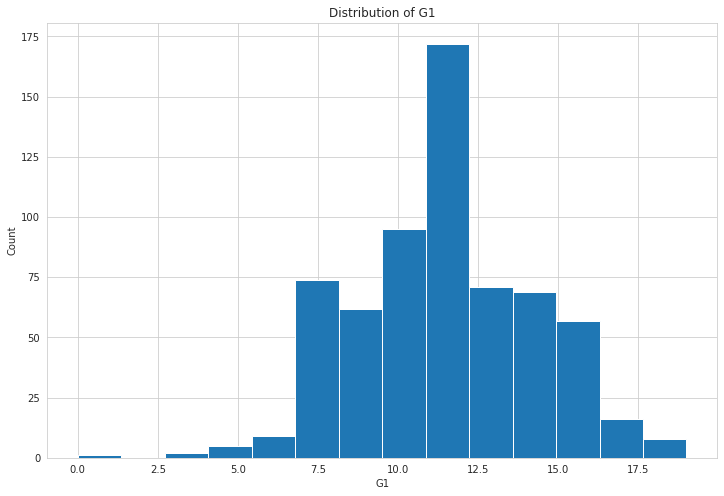

In [7]:
#### ADD CODE HERE 
#### ADD CODE HERE 
plt.hist(data['G1'], bins = 14)
plt.xlabel('G1')
plt.ylabel('Count')
plt.title('Distribution of G1')

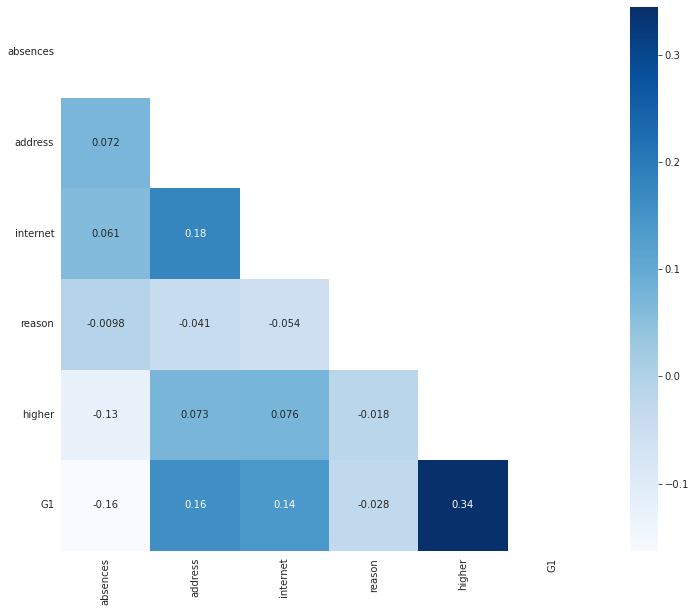

In [8]:
plt.figure(figsize=(12,10))
corr_mask = np.triu(data.corr())
h_map = sns.heatmap(data.corr(), mask=corr_mask, annot=True, cmap='Blues')
plt.yticks(rotation=360)
plt.xticks(rotation=90)
plt.show()
#Looking for a correlation!

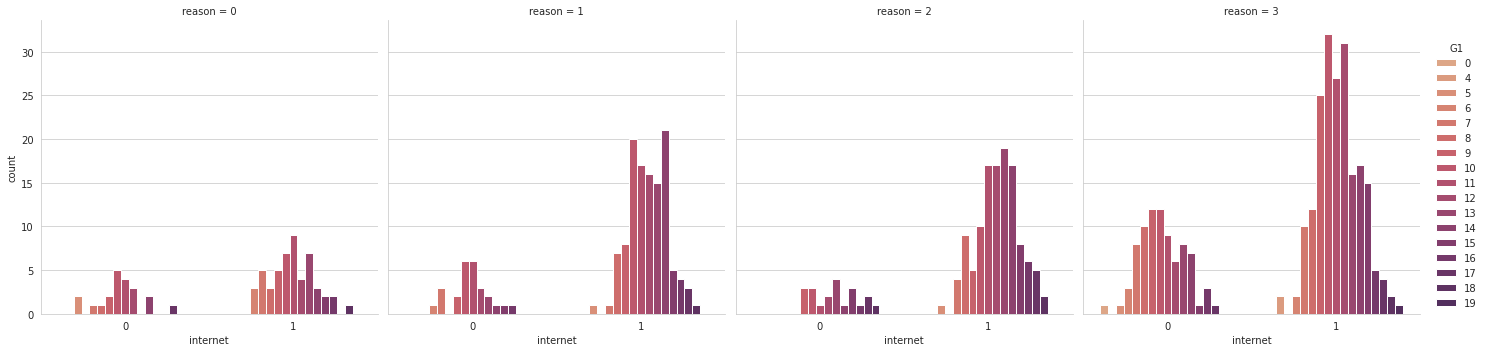

In [9]:
#plot showing if the person wants to continue education, based on the reasons for chosing the school, and also showing the grade
sns.catplot(x='internet', hue='G1', col='reason', data=data, kind='count', palette='flare')
plt.show()

### Naive Estimation: Part 1

Estimate the `absences` to `G1` naively using linear regression. 

To be consistent, please use statsmodels library for that. The API is:

```
sm.OLS.from_formula(formula="your_formula here", data=data) 
res = model.fit()
res.summary()
```

What do you observe here? 

In [10]:
#### ADD CODE HERE
data.corr()['G1'].sort_values()

absences   -0.162674
reason     -0.027723
internet    0.139698
address     0.159834
higher      0.344160
G1          1.000000
Name: G1, dtype: float64

In [11]:
lm = sm.OLS.from_formula('G1 ~ absences', data)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     17.37
Date:                Thu, 05 May 2022   Prob (F-statistic):           3.50e-05
Time:                        15:47:24   Log-Likelihood:                -1548.3
No. Observations:                 641   AIC:                             3101.
Df Residuals:                     639   BIC:                             3109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7869      0.141     83.803      0.000      11.511      12.063
absences      -0.1118      0.027     -4.168      0.000      -0.164      -0.059
==============================================================================
Omnibus:                        0.654   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.516
Skew:                          -0.055   Prob(JB):                        0.773
Kurtosis:                       3.084   Cond. No.                         6.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Starting from R-squared we can see that the regression model with abcenses as independet variable explaines the changes of grade by 2.6 percent.
Coefficent of absences is significant and shows that for every absence the grade is expected to go sown by 0.1118.

### Naive Estimation Part 2

Now try to fit a linear regression using all available variables. 
 - What do you observe? 
 - What are the differences? 
 - What is the relative percentage difference between this estimate and previous one?
 - Which result to trust ?

In [12]:
#### ADD CODE HERE
lm = sm.OLS.from_formula('G1 ~ absences + address + higher + internet + reason', data)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     24.94
Date:                Thu, 05 May 2022   Prob (F-statistic):           5.51e-23
Time:                        15:47:24   Log-Likelihood:                -1499.4
No. Observations:                 641   AIC:                             3011.
Df Residuals:                     635   BIC:                             3038.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2791      0.429     19.315      0.000       7.437       9.121
absences      -0.0958      0.025     -3.793      0.000      -0.145      -0.046
address        0.7675      0.221      3.471      0.001       0.333       1.202
higher         2.7753      0.330      8.406      0.000       2.127       3.424
internet       0.6546      0.240      2.724      0.007       0.183       1.126
reason        -0.0337      0.094     -0.357      0.721      -0.219       0.152
==============================================================================
Omnibus:                        2.527   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                2.626
Skew:                          -0.040   Prob(JB):                        0.269
Kurtosis:                       3.303   Cond. No.                         28.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When we use all the available variables we can see that the change of the dependent variable by the independent variables is explained by 16.4%. 
In this model the effect of absences on the grade is still sifginficant but it becomes less. 
Except for the reason all the remaining variables has significant coefficent and change the grade. 
Expected value of the grade of the student from urban area is 0.7675 higher.
Expected value of the grade of the student who wants to get a higher education is 2.7753 higher.
Expected value of the grade of the student who has access to inernet is 0.6546 higher.

### Learning DAG Structure

- Describe the structure you have learned
- Given the results from Naive Estimation Part2, is your graph consistent with the results or not?
- Where your learned structure is correct and where it is not?
- Wherever your Structure is incorrect complete the graph by adding/removing edges. (in case you add an edge, please color it red)

In [13]:
np.random.seed(42)

weight_matrix = linear.notears_linear(data.values.astype(np.float32), lambda1=0.05, loss_type='l2')
assert utils.is_dag(weight_matrix)
weight_matrix

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.57323613,  0.        ,  0.        ,  0.        ,  0.        ,
         0.53176991],
       [ 0.43042433,  0.        ,  0.        ,  0.        ,  0.        ,
         0.38801001],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.5199437 ,  0.        ,  0.        ,  0.        ,  0.        ,
         2.42865074],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [14]:
col_names  = data.columns.tolist()
num_cols = len(col_names)

dot = Digraph(comment='students', format='png')

for col in col_names:
    dot.node(col)

for ix in range(num_cols):
    edge_candidates = np.where(weight_matrix[ix, :] != 0)[0]
    for ec in edge_candidates:
        dot.edge(col_names[ix], col_names[ec], constraint="true")

- Describe the structure you have learned

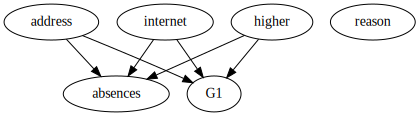

In [15]:
dot

Absences and grade(G1) share three parents: address, internet and gigher. There is no endge between abscences and grade (G1), but there is causal association between them through the three forks. Reason is not connected to anything.

- Given the results from Naive Estimation Part2, is your graph consistent with the results or not?
- Where your learned structure is correct and where it is not?

In part two we did linear regression for grade and found out that internet, adress and the intention for higher education are likely to be parents of the grade (because change in these variables causes significan effect in the grace). Now we want to do linear regression for absences as well.

In [16]:
lm = sm.OLS.from_formula('absences ~ G1  + address + higher + internet + reason', data)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               absences   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     6.324
Date:                Thu, 05 May 2022   Prob (F-statistic):           9.66e-06
Time:                        15:47:30   Log-Likelihood:                -1781.7
No. Observations:                 641   AIC:                             3575.
Df Residuals:                     635   BIC:                             3602.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9932      0.804      7.450      0.000       4.413       7.573
G1            -0.2312      0.061     -3.793      0.000      -0.351      -0.112
address        0.7853      0.345      2.274      0.023       0.107       1.463
higher        -1.0882      0.539     -2.019      0.044      -2.146      -0.030
internet       0.6906      0.374      1.844      0.066      -0.045       1.426
reason        -0.0304      0.147     -0.207      0.836      -0.318       0.258
==============================================================================
Omnibus:                      124.588   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.901
Skew:                           1.232   Prob(JB):                     8.72e-45
Kurtosis:                       4.234   Cond. No.                         65.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that reason and internet are not significant with significance level 0.05. In our graph, reason is not effecting absences, which is consistent with the regressioon results. However, there is an edge from internet to abscence, which, according to the model, is incorrect.

Although there is no edge between absences and grade in the graph, grade is significant in the rgression. In the graph, there is only causal association flow from abscence to grade, but we think that there should be also an edge, because missing to many lectures can affect course material comprehention and thus the grade.

- Wherever your Structure is incorrect complete the graph by adding/removing edges. (in case you add an edge, please color it red)

In [17]:
weight_matrix [2][0]=0
weight_matrix [1][5]=0
weight_matrix[0][5] = 1


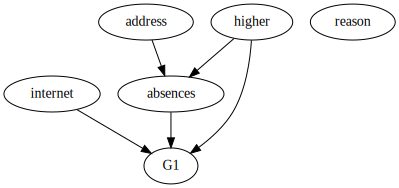

In [18]:
col_names  = data.columns.tolist()
num_cols = len(col_names)

dot1 = Digraph(comment='students', format='png')

for col in col_names:
    dot1.node(col)

for ix in range(num_cols):
    edge_candidates = np.where(weight_matrix[ix, :] != 0)[0]
    for ec in edge_candidates:
        dot1.edge(col_names[ix], col_names[ec], constraint="true")
dot1

### Estimating ACE

- Given a correct structure that you learned and modified from the previous example, fit a linear regression and estimate the `ACE` of `absences` on `G1`.
- Estimate relative percentage differences between Naive Estimation 1 and 2

In [19]:

lm = sm.OLS.from_formula('G1 ~ absences  + address + higher + internet ', data)
lmr = sm.OLS.from_formula('G1 ~  address + higher + internet', data)
model = lm.fit()
modelr = lmr.fit()



In [20]:
y =data["G1"]
X = data[["absences", "address", "higher", "internet"]]
y_pred = model.predict(X)


In [21]:
X = data[["address", "higher", "internet"]]
y_red = modelr.predict(X)

In [22]:
(y_pred - y_red).mean()

-3.1716698949977953e-15

### Structural Equation Model (SEM)

- Write down the SEM corresponding to your graph

In [23]:
lm1 = sm.OLS.from_formula('G1 ~ absences  + address + higher + internet', data)
result = lm1.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     31.19
Date:                Thu, 05 May 2022   Prob (F-statistic):           9.78e-24
Time:                        15:47:31   Log-Likelihood:                -1499.5
No. Observations:                 641   AIC:                             3009.
Df Residuals:                     636   BIC:                             3031.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2058      0.376     21.824      0.000       7.467       8.944
absences      -0.0958      0.025     -3.793      0.000      -0.145      -0.046
address        0.7699      0.221      3.486      0.001       0.336       1.204
higher         2.7767      0.330      8.416      0.000       2.129       3.425
internet       0.6585      0.240      2.746      0.006       0.188       1.130
==============================================================================
Omnibus:                        2.588   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.274   Jarque-Bera (JB):                2.699
Skew:                          -0.043   Prob(JB):                        0.259
Kurtosis:                       3.306   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
from semopy import Model
import semopy 

In [25]:
mod = """
# regression
    G1 ~ absences + internet + higher + address
    absences ~ G1 + address + higher
    """

In [26]:
m = Model(mod)

In [27]:
m.fit(data, obj="MLW", solver="SLSQP")

SolverResult(fun=6.773112051217112e-07, success=True, n_it=64, x=array([-0.43521558,  0.84951417,  2.17531335,  0.98156466,  0.90952609,
       -0.02384608, -4.44910361, 23.57182775,  8.09549916]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW')

In [28]:
g = semopy.semplot(m, "model.png")

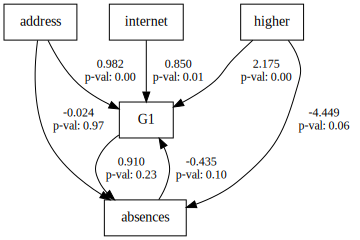

In [29]:
g

In [30]:
m.inspect(mode='list', what="names", std_est=True)

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,G1,~,absences,-0.435216,-0.632913,0.262334,-1.659014,0.097113
1,G1,~,internet,0.849514,0.130976,0.306891,2.768129,0.005638
2,G1,~,higher,2.175313,0.242354,0.593144,3.667427,0.000245
3,G1,~,address,0.981565,0.164452,0.297561,3.298703,0.000971
4,absences,~,G1,0.909526,0.625425,0.758027,1.199859,0.230194
5,absences,~,address,-0.023846,-0.002747,0.741728,-0.032149,0.974353
6,absences,~,higher,-4.449104,-0.340848,2.358586,-1.886343,0.059249
7,absences,~~,absences,23.571828,1.478083,11.219878,2.100899,0.035650
8,G1,~~,G1,8.095499,1.073565,2.804325,2.886790,0.003892


### Interventional Distribution

- Draw the graph corresponding to the Interventional Distribution

In [31]:
weight_matrix[4][0]=0

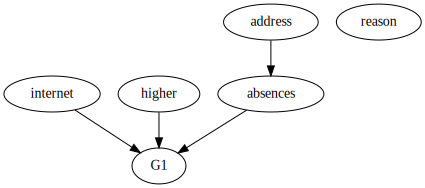

In [32]:
col_names  = data.columns.tolist()
num_cols = len(col_names)

dot2 = Digraph(comment='students', format='png')

for col in col_names:
    dot2.node(col)

for ix in range(num_cols):
    edge_candidates = np.where(weight_matrix[ix, :] != 0)[0]
    for ec in edge_candidates:
        dot2.edge(col_names[ix], col_names[ec], constraint="true")
dot2

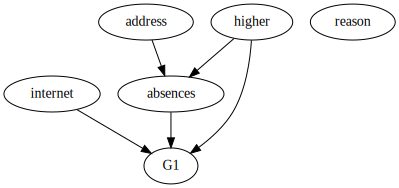

In [33]:
dot1